In [3]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data, util
from skimage.measure import label, regionprops
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression


%matplotlib inline

### Load Training Data

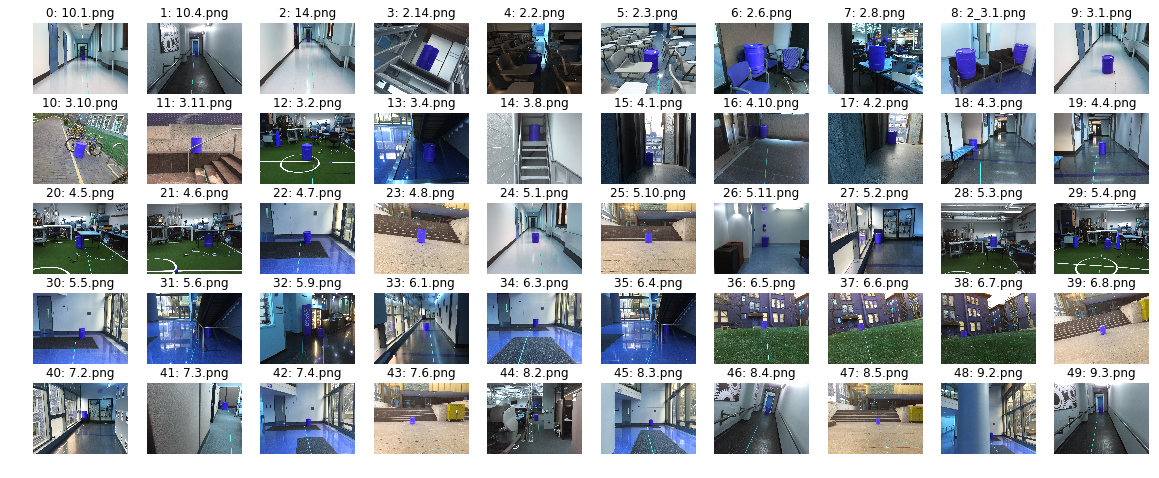

In [4]:
dir_train = "./2019Proj1_train/"
train_list = np.array(os.listdir(dir_train))
train_X = []

PLT_COL = 10 
PLT_ROW = int(math.ceil(len(train_list) / float(PLT_COL)))

plt.figure(figsize=[20, 8])
for i in range(len(train_list)):
    pic = cv2.imread(dir_train + train_list[i])
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(pic)
    plt.axis("off")
    plt.title(str(i) + ": " + train_list[i])
    train_X.append(pic)

train_X = np.array(train_X)

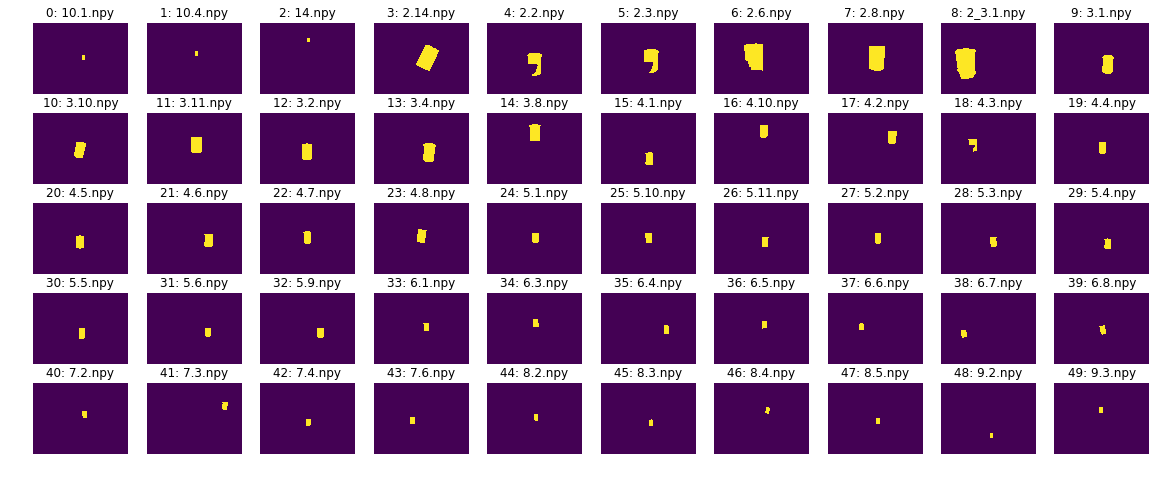

In [5]:
dir_labeled_train = "./labeled_train/"
label_list = os.listdir(dir_labeled_train)
train_Y = []

PLT_COL = 10 
PLT_ROW = int(math.ceil(len(label_list) / float(PLT_COL)))

plt.figure(figsize=[20, 8])
for i in range(len(label_list)):
    labeled = np.load(dir_labeled_train + label_list[i])
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(labeled)
    plt.axis("off")
    plt.title(str(i) + ": " + label_list[i])
    train_Y.append(labeled)

train_Y = np.array(train_Y)

### Color Space Conversion

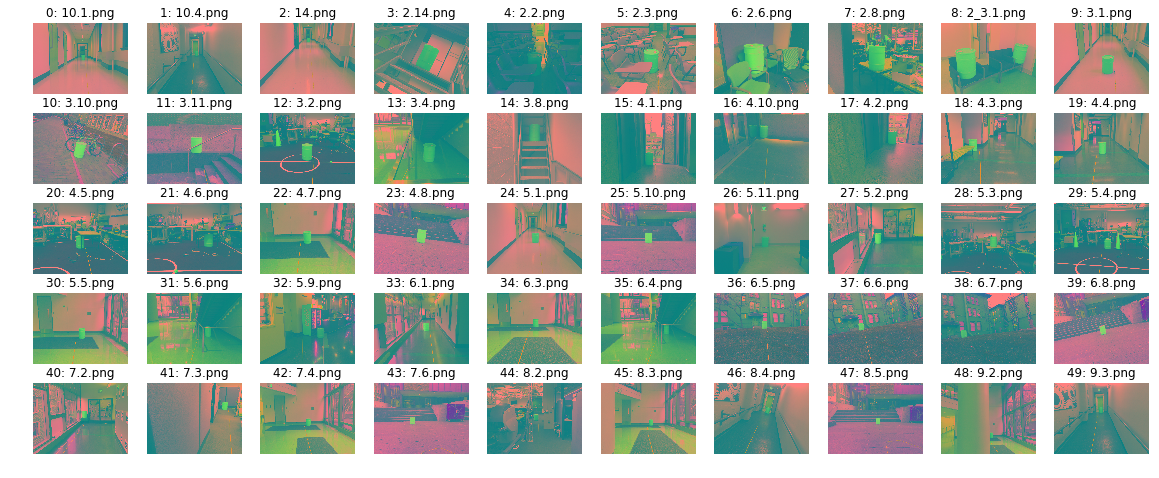

In [6]:
PLT_COL = 10 
PLT_ROW = int(math.ceil(len(train_X) / float(PLT_COL)))

conv_train_X = []
plt.figure(figsize=[20, 8])
for i in range(len(train_X)):
    conv_img = cv2.cvtColor(train_X[i], cv2.COLOR_BGR2YCR_CB)
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(conv_img)
    plt.axis("off")
    plt.title(str(i) + ": " + train_list[i])
    conv_train_X.append(conv_img)
    
conv_train_X = np.array(conv_train_X)

### Hold out 20% for Testing

In [7]:
split_ratio = 0.2

dev_test_size = int(len(train_Y) * split_ratio)
dev_train_size = len(train_Y) - dev_test_size

indices = sorted(random.sample(range(len(train_Y)), dev_test_size))

x_train_dev = np.array([conv_train_X[i] for i in range(len(conv_train_X)) if i not in indices])
x_test_dev = conv_train_X[indices]
y_train_dev = np.array([train_Y[i] for i in range(len(train_Y)) if i not in indices])
y_test_dev = train_Y[indices]
name_train_dev = np.array([train_list[i] for i in range(len(train_list)) if i not in indices])
name_test_dev = train_list[indices]

print("Picked:", indices)
print(x_train_dev.shape, x_test_dev.shape, y_train_dev.shape, y_test_dev.shape)
print("training set: ", name_train_dev)
print("test set: ", name_test_dev)

('Picked:', [2, 6, 7, 13, 24, 26, 32, 43, 44, 45])
((40, 900, 1200, 3), (10, 900, 1200, 3), (40, 900, 1200), (10, 900, 1200))
('training set: ', array(['10.1.png', '10.4.png', '2.14.png', '2.2.png', '2.3.png',
       '2_3.1.png', '3.1.png', '3.10.png', '3.11.png', '3.2.png',
       '3.8.png', '4.1.png', '4.10.png', '4.2.png', '4.3.png', '4.4.png',
       '4.5.png', '4.6.png', '4.7.png', '4.8.png', '5.10.png', '5.2.png',
       '5.3.png', '5.4.png', '5.5.png', '5.6.png', '6.1.png', '6.3.png',
       '6.4.png', '6.5.png', '6.6.png', '6.7.png', '6.8.png', '7.2.png',
       '7.3.png', '7.4.png', '8.4.png', '8.5.png', '9.2.png', '9.3.png'],
      dtype='|S9'))
('test set: ', array(['14.png', '2.6.png', '2.8.png', '3.4.png', '5.1.png', '5.11.png',
       '5.9.png', '7.6.png', '8.2.png', '8.3.png'], dtype='|S9'))


In [8]:
x_train_px_dev = np.reshape(x_train_dev, (dev_train_size * 900 * 1200, 3))
y_train_px_dev = np.reshape(y_train_dev, (dev_train_size * 900 * 1200))
x_test_px_dev = np.reshape(x_test_dev, (dev_test_size * 900 * 1200, 3))
y_test_px_dev = np.reshape(y_test_dev, (dev_test_size * 900 * 1200))
print "x_train_px_dev: ", x_train_px_dev.shape
print "y_train_px_dev: ", y_train_px_dev.shape
print "x_test_px_dev: ", x_test_px_dev.shape
print "y_test_px_dev: ", y_test_px_dev.shape

x_train_px_dev:  (43200000, 3)
y_train_px_dev:  (43200000,)
x_test_px_dev:  (10800000, 3)
y_test_px_dev:  (10800000,)


### GMM for color segmentation

#### Sklearn

In [9]:
# %%time 

# model = GaussianMixture(n_components=10)
# model.fit([x_train_px_dev[i] for i in range(len(x_train_px_dev)) if y_train_px_dev[i]])

CPU times: user 2min 13s, sys: 31.5 s, total: 2min 45s
Wall time: 1min 9s


#### Self-Implementation

In [119]:
class GaussianMixture_EM:
    def __init__(self, N=2, X=np.array([]), tol=1e-3, max_iter=100, mus_init=None):
        self.N = N
        self.X = self.__scale(X)
        self.size, self.dimen = X.shape
        self.tol = tol
        self.max_iter = max_iter
        
        # means
        self.mus = mus_init if mus_init else np.random.rand(self.N, self.dimen)
        
        # covs
        self.covs = []
        cov_diags = np.random.rand(self.N, self.dimen)
        for diag in cov_diags:
            self.covs.append(np.diag(diag))
        self.covs = np.array(self.covs)
        
        # pis
        pis = []
        remain = 1
        for rand in np.random.rand(self.N - 1):
            pis.append(rand)
            remain -= remain * rand
        pis.append(remain)
        self.pis = np.array(pis)
        
        
    def __scale(self, pixels):
        return np.array(pixels / 255.0)

    
    def __prior_probability(self, X):
        prob_x_n = np.zeros((len(X), self.N))
        for n in range(self.N):
            prob_x_n[:, n] = multivariate_normal.pdf(X, mean=self.mus[n], cov=self.covs[n])
        
        return prob_x_n
    
    
    def __Expection(self):
        # p(x|n) - prior probability
        prob_x_n = self.__prior_probability(self.X)
        
        # p(n|x) - gamma - responsibility
        prob_n_x = np.zeros((self.size, self.N))
        for n in range(self.N):
            prob_n_x[:, n] = self.pis[n] * prob_x_n[:, n]     # numerator = p(n) * p(x|n) 
        prob_n_x = prob_n_x / prob_n_x.sum(1, keepdims=True)  # denomenator = p(x) = sum of all p(n) * p(x|n)
        
        return prob_n_x
        
        
    def __Maximization(self, gammas):
        mus_new = np.zeros((self.N, self.dimen))
        covs_new = []
        pis_new = np.zeros(self.N)
        
        # update weights, means and variances for each model
        for n in range(self.N):
            # sum of gammas
            sum_gamma = np.sum(gammas[:, n])
            
            # mean
            for f in range(self.dimen):
                mus_new[n, f] = np.sum(np.multiply(gammas[:, n], self.X[:, f])) / np.sum(gammas[:, n])
            
            # cov
            cov_diag = np.zeros(self.dimen)
            for f in range(self.dimen):
                cov_diag[f] = np.sum(np.multiply(gammas[:, n], np.square(self.X[:, f] - self.mus[n, f])))
            
            cov_diag /= np.sum(gammas[:, n])
            covs_new.append(np.diag(cov_diag))
            
            # pi
            pis_new[n] = np.sum(gammas[:, n] / self.size)
        
        self.mus = mus_new
        self.covs = covs_new
        self.pis = pis_new
    
        
    def run(self):
        log_likelihoods = []
        iteration = 0
        while iteration < self.max_iter:
            iteration += 1
            print(iteration)
            
            # Expection
            gammas = self.__Expection()
            
            # Maximization
            self.__Maximization(gammas)
            
            # log-likelihood
            likelihood = np.zeros(self.size)
            for n in range(self.N):
                likelihood += multivariate_normal.pdf(self.X, self.mus[n], self.covs[n]) * self.pis[n]
            log_likelihoods.append(np.sum(np.log10(likelihood)))
            
            # noise resistance
            if iteration > 5 and \
               abs(np.mean(log_likelihoods[iteration - 2 : iteration]) - \
                   np.mean(log_likelihoods[iteration - 5 : iteration - 2])) \
               / abs(log_likelihoods[-1]) < self.tol:
                break
        
        return iteration
        
        
    def score_samples(self, test_X):
        test_X = self.__scale(test_X)
        prob_x_n = self.__prior_probability(test_X)
        return np.log(np.sum(np.exp(np.log(prob_x_n) + np.log(self.pis)), axis=1))

In [113]:
%%time
model = GaussianMixture_EM(2, x_train_px_dev)
iters = model.run()
print("Done:", "iters:" + str(iters))

1
2
3
4
5
6
7
8
9
10
11
('Done:', 'iters:11')
CPU times: user 4min 17s, sys: 2min 14s, total: 6min 32s
Wall time: 5min 48s


CPU times: user 13 s, sys: 2.02 s, total: 15 s
Wall time: 8.82 s


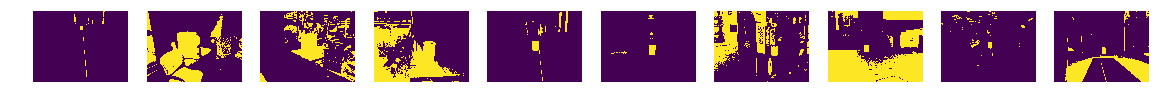

In [118]:
%%time

THRESH = 2 #-14
N_ROW = 900
N_COL = 1200

predicts = []
for i in range(len(x_test_dev)):
    res = model.score_samples(np.reshape(x_test_dev[i], (N_ROW * N_COL, 3)))
    predicts.append(np.reshape([False if x > THRESH else True for x in res], (N_ROW, N_COL)))


PLT_COL = len(pred_regions_dev)
PLT_ROW = int(math.ceil(len(y_test_dev) / float(PLT_COL)))
plt.figure(figsize=[20, 5])
for i in range(len(y_test_dev)):
    axes = plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(predicts[i])
    plt.axis("off")

#### Label Region

CPU times: user 722 ms, sys: 47.7 ms, total: 770 ms
Wall time: 770 ms


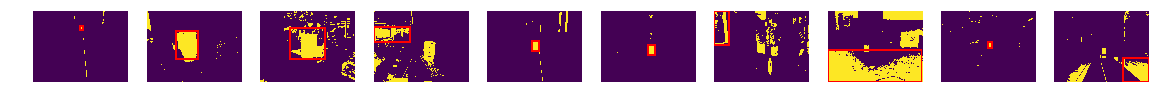

In [94]:
%%time

BARREL_RATIO_MAX = 3.5
BARREL_RATIO_MIN = 1.00
AREA_MIN = 1000
AREA_RATIO_MIN = 0.3
NUM_BARRELS_PICKING = 1

pred_regions_dev = []
for pred in predicts:
    img = util.img_as_ubyte(pred)
    labeled = label(img, connectivity=img.ndim) 
    
    rects = []
    for region in regionprops(labeled):
        if region.area >= AREA_MIN and float(region.area) / region.convex_area > AREA_RATIO_MIN:
            minr, minc, maxr, maxc = region.bbox
            h, w = float(maxr - minr), float(maxc - minc)
            ratio = max(h, w) / min(h, w)
            if ratio < BARREL_RATIO_MIN or ratio > BARREL_RATIO_MAX:
                continue
            
            rects.append(((minc, minr), w, h, region))
            
    rects.sort(key=lambda x: x[3].area)  
    pred_regions_dev.append(rects[-NUM_BARRELS_PICKING:])
    

PLT_COL = len(pred_regions_dev)
PLT_ROW = int(math.ceil(len(y_test_dev) / float(PLT_COL)))
plt.figure(figsize=[20, 5])
for i in range(len(y_test_dev)):
    axes = plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(predicts[i])
    plt.axis("off")
    dist = []
    for rect in pred_regions_dev[i]:
        axes.add_patch(mpatches.Rectangle(rect[0], rect[1], rect[2], fill=False, edgecolor='red', linewidth=2))

### Linear Regession for distance computing

#### Label Region

CPU times: user 1.74 s, sys: 238 ms, total: 1.97 s
Wall time: 2.07 s


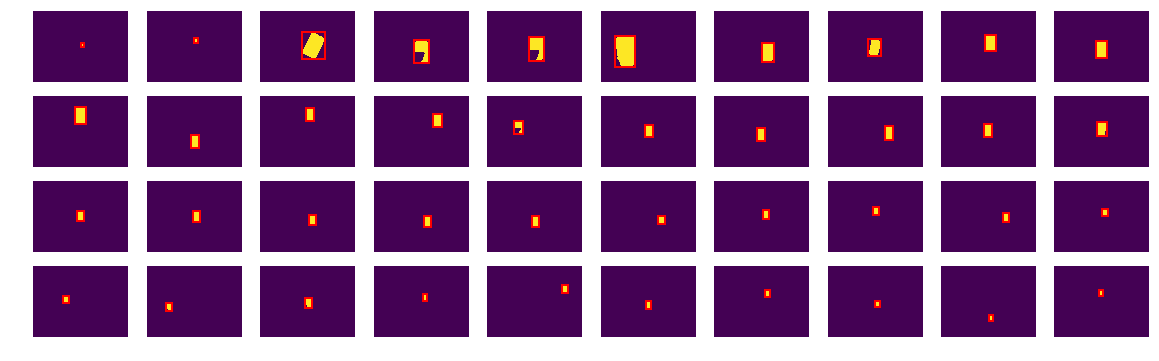

In [57]:
%%time

BARREL_RATIO_MAX = 3
BARREL_RATIO_MIN = 1
AREA_MIN = 100
AREA_RATIO_MIN = 0.15
NUM_BARRELS_PICKING = 1


train_regions_dev = []
for t in y_train_dev:
    img = util.img_as_ubyte(t)
    labeled = label(img, connectivity=img.ndim) 
    
    rects = []
    for region in regionprops(labeled):
        if region.area >= AREA_MIN and float(region.area) / region.convex_area > AREA_RATIO_MIN:
            minr, minc, maxr, maxc = region.bbox
            h, w = float(maxr - minr), float(maxc - minc)
            ratio = max(h, w) / min(h, w)
            if ratio < BARREL_RATIO_MIN or ratio > BARREL_RATIO_MAX:
                continue
            
            rects.append(((minc, minr), w, h, region))
            
    rects.sort(key=lambda x: x[3].area)  
    train_regions_dev.append(rects[-NUM_BARRELS_PICKING:])


PLT_COL = 10
PLT_ROW = int(math.ceil(len(train_regions_dev) / float(PLT_COL)))

plt.figure(figsize=[20, 6])
for i in range(len(train_regions_dev)):
    axes = plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(y_train_dev[i])
    plt.axis("off")
    dist = []
    for rect in train_regions_dev[i]:
        axes.add_patch(mpatches.Rectangle(rect[0], rect[1], rect[2], fill=False, edgecolor='red', linewidth=2))

#### Get Distance (Y)

In [ ]:
# Y:  distance

train_dist_y_dev = []
for name in name_train_dev:
    train_dist_y_dev.append(int(name.split(".")[0].split("_")[0]))
    
test_dist_y_dev = []
for name in name_test_dev:
    test_dist_y_dev.append(int(name.split(".")[0].split("_")[0]))

train_dist_y_dev = np.array(train_dist_y_dev)
test_dist_y_dev = np.array(test_dist_y_dev)
print(train_dist_y_dev.shape)
print(test_dist_y_dev.shape)

#### Get Input Features (X)

In [ ]:
# X:  center_X, center_Y, width, height, orientation

train_dist_x_dev = []
for region in train_regions_dev:
    region = region[0]
    train_dist_x_dev.append([region[3].centroid[0], 
                             region[3].centroid[1],
                             region[1],
                             region[2],
                             region[3].orientation]) 
    
test_dist_x_dev = []
for region in pred_regions_dev:
    region = region[0]
    test_dist_x_dev.append([region[3].centroid[0], 
                            region[3].centroid[1],
                            region[1],
                            region[2],
                            region[3].orientation]) 
    
train_dist_x_dev = np.array(train_dist_x_dev)
test_dist_x_dev = np.array(test_dist_x_dev)
print(train_dist_x_dev.shape)
print(test_dist_x_dev.shape)

In [ ]:
PLT_COL = 10 
PLT_ROW = int(math.ceil(len(y_train_dev) / float(PLT_COL)))

plt.figure(figsize=[20, 7])
for i in range(len(y_train_dev)):
    axes = plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(y_train_dev[i])
    plt.axis("off")
    dist = []
    for rect in train_regions_dev[i]:
        axes.add_patch(mpatches.Rectangle(rect[0], rect[1], rect[2], fill=False, edgecolor='red', linewidth=2))

    plt.title("Distance: " + str(train_dist_y_dev[i])) 

In [ ]:
model = LinearRegression().fit(train_dist_x_dev, train_dist_y_dev)
pred_dist_dev = np.absolute(model.predict(test_dist_x_dev))
score = model.score(test_dist_x_dev, test_dist_y_dev)
print("Linear Regression: score:", score)

#### Results

In [ ]:
PLT_COL = 4 
PLT_ROW = len(y_test_dev)


plt.figure(figsize=[10, 20])
for i in range(len(y_test_dev)):
    plt.subplot(PLT_ROW, PLT_COL, i * PLT_COL + 1)
    plt.imshow(x_test_dev[i])
    plt.axis("off")
    plt.title(name_test_dev[i]) 
    
    plt.subplot(PLT_ROW, PLT_COL, i * PLT_COL + 2)
    plt.imshow(y_test_dev[i])
    plt.axis("off")
    plt.title("Distance: " + "{0:.0f}".format(test_dist_y_dev[i])) 
    
    plt.subplot(PLT_ROW, PLT_COL, i * PLT_COL + 3)
    plt.imshow(predicts[i])
    plt.axis("off")
    
    
    axes = plt.subplot(PLT_ROW, PLT_COL, i * PLT_COL + 4)
    plt.imshow(predicts[i])
    plt.axis("off")
    dist = []
    for rect in pred_regions_dev[i]:
        axes.add_patch(mpatches.Rectangle(rect[0], rect[1], rect[2], fill=False, edgecolor='red', linewidth=2))
    plt.title("Distance: " + "{0:.2f}".format(pred_dist_dev[i])) 